In [2]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from keras.layers import LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize MediaPipe face detection and face mesh
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

In [8]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    landmarks = []
    
    with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_frame)
            
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    landmark = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
                    landmarks.append(landmark)
    
    cap.release()
    print(len(landmarks))
    return landmarks

def process_directory(directory):
    data = []
    labels = []
    
    for label in ['Deceptive', 'Truthful']:
        videos_path = os.path.join(directory, label)
        for video_name in os.listdir(videos_path):
            video_path = os.path.join(videos_path, video_name)
            print(video_name)
            video_landmarks = process_video(video_path)
            data.extend(video_landmarks)
            labels.extend([label] * len(video_landmarks))
    
    return data, labels



In [9]:
data_dir = 'Real-life_Deception_Detection_2016/Clips'
features, labels = process_directory(data_dir)
df = pd.DataFrame({'landmarks': features, 'label': labels})

# Split into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)



trial_lie_001.mp4
500
trial_lie_002.mp4
1874
trial_lie_003.mp4
212
trial_lie_004.mp4
349
trial_lie_005.mp4
1567
trial_lie_006.mp4
546
trial_lie_007.mp4
1402
trial_lie_008.mp4
202
trial_lie_009.mp4
619
trial_lie_010.mp4
788
trial_lie_011.mp4
1010
trial_lie_012.mp4
237
trial_lie_013.mp4
571
trial_lie_014.mp4
415
trial_lie_015.mp4
1030
trial_lie_016.mp4
1108
trial_lie_017.mp4
1285
trial_lie_018.mp4
1035
trial_lie_019.mp4
1102
trial_lie_020.mp4
334
trial_lie_021.mp4
523
trial_lie_022.mp4
1244
trial_lie_023.mp4
1266
trial_lie_024.mp4
735
trial_lie_025.mp4
884
trial_lie_026.mp4
855
trial_lie_027.mp4
808
trial_lie_028.mp4
727
trial_lie_029.mp4
590
trial_lie_030.mp4
1132
trial_lie_031.mp4
777
trial_lie_032.mp4
699
trial_lie_033.mp4
1125
trial_lie_034.mp4
750
trial_lie_035.mp4
350
trial_lie_036.mp4
1057
trial_lie_037.mp4
682
trial_lie_038.mp4
621
trial_lie_039.mp4
810
trial_lie_040.mp4
648
trial_lie_041.mp4
713
trial_lie_042.mp4
679
trial_lie_043.mp4
341
trial_lie_044.mp4
268
trial_lie_045.mp4


In [13]:
print(len(features))
print(len(labels))


81559
81559


In [11]:
# Convert landmarks from lists to numpy arrays for processing
train_features = np.array([np.array(x) for x in train_df['landmarks']])
val_features = np.array([np.array(x) for x in val_df['landmarks']])
test_features = np.array([np.array(x) for x in test_df['landmarks']])

# Pad sequences to the same length
train_features_padded = pad_sequences(train_features, padding='post', dtype='float32')
val_features_padded = pad_sequences(val_features, padding='post', dtype='float32')
test_features_padded = pad_sequences(test_features, padding='post', dtype='float32')

# Ensure labels are in the correct shape
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

In [15]:
print(train_features_padded.shape)
print(val_features_padded.shape)
print(test_features_padded.shape)

(48935, 468, 3)
(16312, 468, 3)
(16312, 468, 3)


In [7]:
# Save features and labels to a single .pkl file
data_dict = {
    'train_features': train_features_padded,
    'val_features': val_features_padded,
    'test_features': test_features_padded,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels
}

with open('features_labels_mediapipe.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

Loading pkl file

In [3]:
import pickle

# Load the data from the .pkl file
with open('features_labels_mediapipe.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# Extract the features and labels from the loaded dictionary
train_features_padded = data_dict['train_features']
val_features_padded = data_dict['val_features']
test_features_padded = data_dict['test_features']
train_labels = data_dict['train_labels']
val_labels = data_dict['val_labels']
test_labels = data_dict['test_labels']

# Print some basic information about the loaded data
print(f'Train features shape: {train_features_padded.shape}')
print(f'Validation features shape: {val_features_padded.shape}')
print(f'Test features shape: {test_features_padded.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

# Check a small sample of the loaded data
print(f'Sample train features: {train_features_padded[0]}')
print(f'Sample train label: {train_labels[0]}')


Train features shape: (48935, 468, 3)
Validation features shape: (16312, 468, 3)
Test features shape: (16312, 468, 3)
Train labels shape: (48935,)
Validation labels shape: (16312,)
Test labels shape: (16312,)
Sample train features: [[ 2.7859533e-01  6.6382325e-01 -3.3328969e-02]
 [ 2.8167385e-01  6.1282730e-01 -5.8617342e-02]
 [ 2.8364891e-01  6.3015389e-01 -3.0833388e-02]
 ...
 [ 3.2265043e-01  5.4067820e-01 -9.6979132e-03]
 [ 3.9301628e-01  5.4282033e-01  7.2184048e-04]
 [ 4.0033460e-01  5.3740424e-01  2.1579450e-04]]
Sample train label: 1


In [4]:
input_shape = train_features_padded.shape[1:]
with tf.device('/GPU:1'):
    model = models.Sequential([
        layers.Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        layers.Dropout(0.2),
        layers.Bidirectional(LSTM(128, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Bidirectional(LSTM(128, return_sequences=False)),
        layers.Dense(1, activation='sigmoid'),
    ])

    learning_rate = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 468, 512)         532480    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 468, 512)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 468, 256)         656384    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 468, 256)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                        

In [5]:
history = model.fit(
    train_features_padded, train_labels,
    validation_data=(val_features_padded, val_labels),
    epochs=10,
    batch_size=128
)

Epoch 1/10
383/383 [==============================] - 115s 286ms/step - loss: 0.5508 - accuracy: 0.7065 - val_loss: 0.4596 - val_accuracy: 0.7906
Epoch 2/10
383/383 [==============================] - 108s 283ms/step - loss: 0.4554 - accuracy: 0.7801 - val_loss: 0.4164 - val_accuracy: 0.8003
Epoch 3/10
383/383 [==============================] - 109s 284ms/step - loss: 0.4312 - accuracy: 0.7930 - val_loss: 0.3930 - val_accuracy: 0.8148
Epoch 4/10
383/383 [==============================] - 109s 285ms/step - loss: 0.4044 - accuracy: 0.8044 - val_loss: 0.3842 - val_accuracy: 0.8146
Epoch 5/10
383/383 [==============================] - 109s 284ms/step - loss: 0.3768 - accuracy: 0.8203 - val_loss: 0.3621 - val_accuracy: 0.8231
Epoch 6/10
383/383 [==============================] - 109s 285ms/step - loss: 0.3387 - accuracy: 0.8435 - val_loss: 0.3039 - val_accuracy: 0.8673
Epoch 7/10
383/383 [==============================] - 109s 284ms/step - loss: 0.3200 - accuracy: 0.8544 - val_loss: 0.2836 -

Accuracy: 0.87965914664051
Confusion Matrix:
[[6800 1513]
 [ 450 7549]]


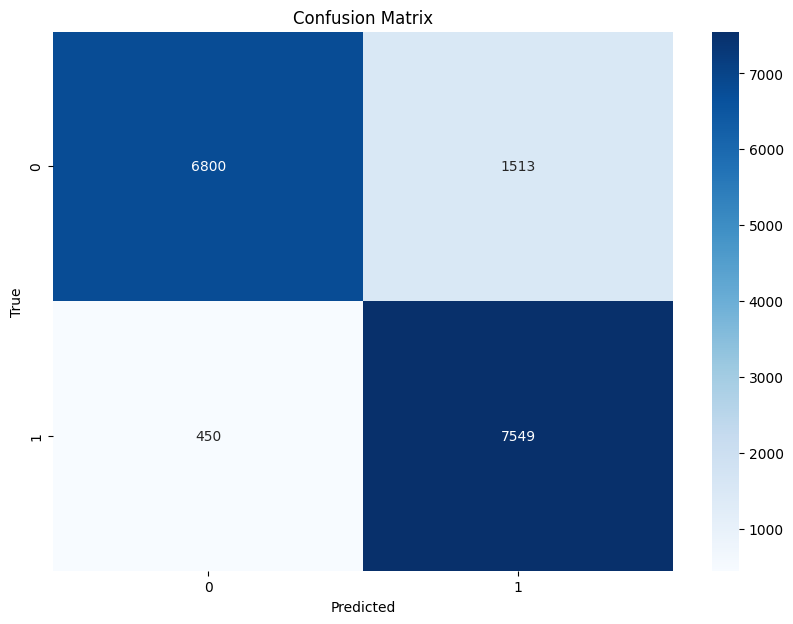

Precision: 0.833039064224233
Recall: 0.9437429678709839
F1 Score: 0.8849422659867534


In [6]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `test_features_padded` and `test_labels` are already defined and the model is trained
# Load your saved model if necessary
# model = tf.keras.models.load_model('path_to_your_model')

with tf.device('/GPU:1'):
    y_pred_prob = model.predict(test_features_padded)
    y_pred = np.round(y_pred_prob).astype(int).flatten()

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    print(f'Accuracy: {accuracy}')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_labels, y_pred)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate precision, recall, and F1-score
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

